In [1]:
import pickle

with open(f'./data/openai_gpt_original_final_results.pkl', 'rb') as infile:
    results = pickle.load(infile)

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np

negent = -1*np.array(results["entropy"])
ent_correct = np.array(results["entropy_correct"]).astype(np.float32)

negdent = -1*np.array(results["dentropy"])
dent_correct = np.array(results["dentropy_correct"]).astype(np.float32)

neg_og_ent = -1*np.array(results["og_entropy"])
og_ent_correct = np.array(results["og_entropy_correct"]).astype(np.float32)

negperp = -1*np.array(results["perplexity"])
perp_correct = np.array(results["perplexity_correct"]).astype(np.float32)

df = pd.DataFrame({
    'SE':negent, 
    'SE_correct':ent_correct, 
    'DSE':negdent, 
    'DSE_correct':dent_correct, 
    'OSE':neg_og_ent, 
    'OSE_correct':og_ent_correct, 
    'Perplexity':negperp, 
    'Perp_correct':perp_correct, 
    })
df

,SE,SE_correct,DSE,DSE_correct,OSE,OSE_correct,Perplexity,Perp_correct
0,22.473374,1.0,0.000000,1.0,-2.714329,1.0,-1.004203,1.0
1,22.714366,1.0,0.000000,1.0,-2.706905,1.0,-1.005363,1.0
2,21.370610,1.0,0.000000,1.0,-2.749248,1.0,-1.008647,1.0
3,9.413133,0.0,-1.088900,0.0,-4.532941,0.0,-1.039408,0.0
4,23.023585,1.0,0.000000,1.0,-2.697484,1.0,-1.000036,1.0
...,...,...,...,...,...,...,...,...
1819,19.148745,0.0,0.000000,0.0,-2.824857,0.0,-1.094265,0.0
1820,14.382250,0.0,-0.610864,0.0,-3.567728,0.0,-1.068390,0.0
1821,8.302005,1.0,-0.897946,1.0,-4.366093,1.0,-1.177898,1.0
1822,18.058362,0.0,0.000000,0.0,-2.864903,0.0,-1.150496,0.0


Text(0.5, 1.0, 'Perplexity')

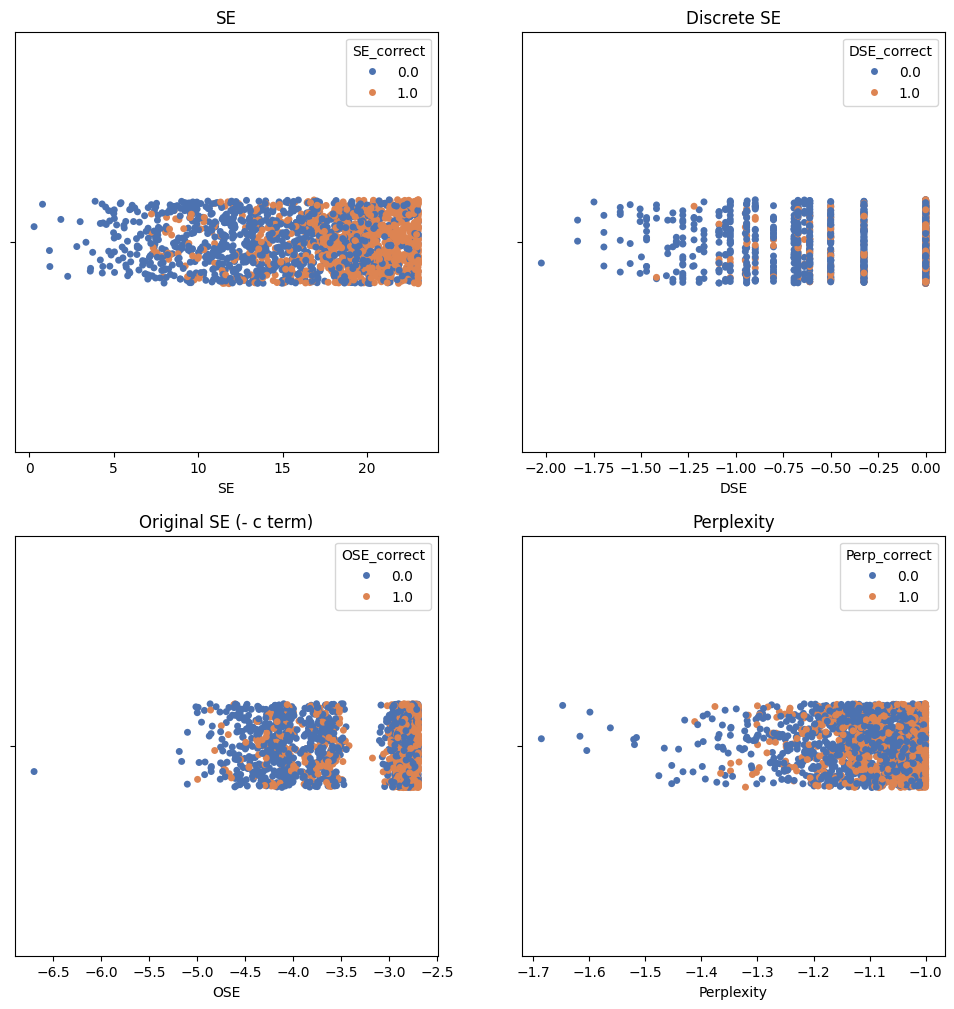

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
sns.stripplot(data=df, x="SE", hue="SE_correct", palette="deep", ax=axes[0,0])
axes[0,0].set_title("SE")
sns.stripplot(data=df, x="DSE", hue="DSE_correct", palette="deep", ax=axes[0,1])
axes[0,1].set_title("Discrete SE")
sns.stripplot(data=df, x="OSE", hue="OSE_correct", palette="deep", ax=axes[1,0])
axes[1,0].set_title("Original SE (- c term)")
sns.stripplot(data=df, x="Perplexity", hue="Perp_correct", palette="deep", ax=axes[1,1])
axes[1,1].set_title("Perplexity")